### **Data Preparation**

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## load data
file_path = "C:/Users/User/Downloads/ageingr.xlsx"
xls = pd.ExcelFile(file_path)

xls.sheet_names

df = pd.read_excel(xls, sheet_name='Sheet1')

df.head()

## Data cleaning
selected_columns = [
    'Age','Priority','Assignment group','Region','Incident state','Reassignment count','Configuration Item',
]

df = df[selected_columns]

# check missing values
missing_values = df.isnull().sum()

# to tackle for missing values like Priority, Assignment group, Configuration Itemm we can use mode. for Region, we can fill in as unknown

df['Priority'].fillna(df['Priority'].mode()[0], inplace=True)
df['Assignment group'].fillna(df['Assignment group'].mode()[0], inplace=True)
df['Configuration Item'].fillna(df['Configuration Item'].mode()[0], inplace=True)

df['Region'].fillna('Unknown', inplace=True)

# check the mv
#df.isnull().sum()

## change categorical to numerical
from sklearn.preprocessing import LabelEncoder

categorical_columns = ['Priority', 'Assignment group', 'Region', 'Incident state', 'Configuration Item','Reassignment count']

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Simpan encoder jika perlu digunakan semula

# Semak data selepas penukaran
df.head()

,Age,Priority,Assignment group,Region,Incident state,Reassignment count,Configuration Item
0,1787,3,104,3,0,2,103
1,1787,3,104,3,0,2,36
2,1786,3,140,1,0,1,219
3,1742,3,104,3,0,2,193
4,1719,3,140,1,0,1,219


### **Train-Test Split**

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X = df.drop(columns=['Age'])
y = df['Age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Training Models**

In [20]:
# Random Forest

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train,y_train)

# Buat ramalan
rf_pred = rf_model.predict(X_test)

In [21]:
# Gradient Boosting

gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbm_model.fit(X_train, y_train)

# Buat ramalan
gbm_pred = gbm_model.predict(X_test)

### **Evaluate Model Performance**

In [22]:
rf_rmse = mean_squared_error(y_test, rf_pred, squared=False)
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

rf_rmse, rf_r2, rf_mae

(147.67032588133554, 0.570972623558788, 71.62148592378719)

Insights for Random Forest:

1) MAE: 71.6 days = Typically, your model's predictions differ from the real ticket age by about 70 days. 
2) RMSE (measures how far predictions usually are from reality): 145.67 days = A high RMSE means your model sometimes predicts ticket ages that are very different from the actual ages.
3) R²: Around 0.57 = This is moderate performance

In [23]:
gbm_rmse = mean_squared_error(y_test, gbm_pred, squared=False)
gbm_r2 = r2_score(y_test, gbm_pred)
gbm_mae = mean_absolute_error(y_test, gbm_pred)

gbm_rmse, gbm_r2, gbm_mae

(157.00581736301015, 0.5150130784539114, 92.76450588833502)

Insights for Gradient Boosting:

1) MAE: 92.8 days = Typically, the model's predictions differ from the real ticket age by about 93 days. 
2) RMSE (measures how far predictions usually are from reality): 157. days = A high RMSE means your model sometimes predicts ticket ages that are very different from the actual ages.
3) R²: Around 0.51 = This is moderate performance

**From both results we can say that Random Forest is much better than GBM for its low RMSE and higher R2**

### **Feature Importance**

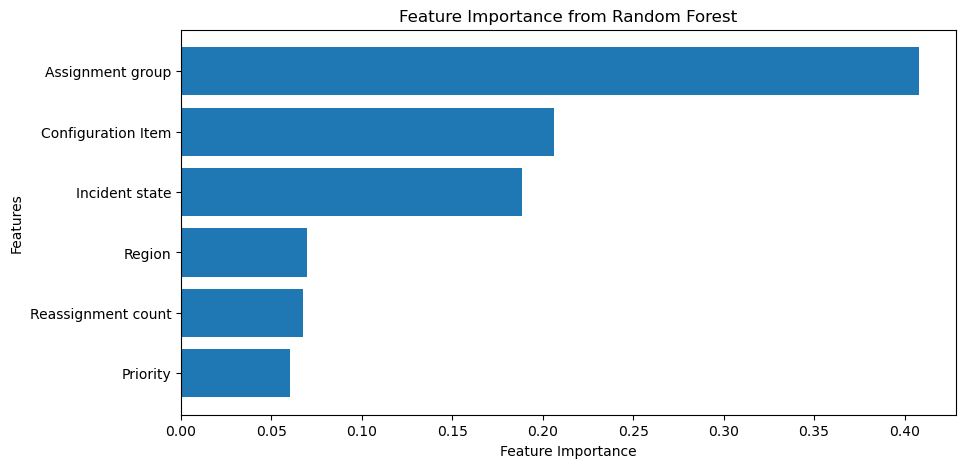

In [24]:
import matplotlib.pyplot as plt

# Dapatkan kepentingan feature daripada model Random Forest
feature_importance = rf_model.feature_importances_


feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualisasi feature importance
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Random Forest")
plt.gca().invert_yaxis()  
plt.show()


In [25]:
# since the model is not that good, we decide to perform hyperparameter tuning

from sklearn.model_selection import RandomizedSearchCV

# Tentukan parameter yang akan diuji
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Buat model Random Forest dengan RandomizedSearchCV untuk cari parameter terbaik
rf_tuned = RandomForestRegressor(random_state=42)
rf_search = RandomizedSearchCV(estimator=rf_tuned, param_distributions=param_grid, 
                               n_iter=10, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)

# Paparkan parameter terbaik
print("Best Parameters:", rf_search.best_params_)

Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


In [26]:
# Train Random Forest with the best hyperparameters

rf_optimized = RandomForestRegressor(
    n_estimators=300, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    max_depth=None, 
    random_state=42
)

rf_optimized.fit(X_train, y_train)

# Predict on the test set
rf_optimized_pred = rf_optimized.predict(X_test)

# Calculate MAE, RMSE, and R² score
rf_optimized_mae = mean_absolute_error(y_test, rf_optimized_pred)
rf_optimized_rmse = mean_squared_error(y_test, rf_optimized_pred, squared=False)
rf_optimized_r2 = r2_score(y_test, rf_optimized_pred)

# Print results
print(f"MAE: {rf_optimized_mae:.2f}")
print(f"RMSE: {rf_optimized_rmse:.2f}")
print(f"R² Score: {rf_optimized_r2:.4f}")

MAE: 71.53
RMSE: 147.63
R² Score: 0.5712


**The improvement is very small**

In [29]:
# lets try with XGBOOST!

%pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 495.5 kB/s eta 0:04:13
   ---------------------------------------- 0.2/124.9 MB 1.8 MB/s eta 0:01:10
   ---------------------------------------- 0.6/124.9 MB 3.5 MB/s eta 0:00:36
   ---------------------------------------- 1.2/124.9 MB 5.6 MB/s eta 0:00:22
    --------------------------------------- 1.7/124.9 MB 6.8 MB/s eta 0:00:19
    --------------------------------------- 2.3/124.9 MB 7.7 MB/s eta 0:00:16
    --------------------------------------- 2.9/124.9 MB 8.3 MB/s eta 0:00:15
   - -------------------------------------- 3.3/124.9 MB 8.5 MB/s eta 0:00:15
   - -------------------------------------- 3.9/124.9 MB 8.8 MB/s eta 0:00:14
   - -------------------------------------- 3.9/124.9 MB 8.8 MB/s eta 0:00:14
   - -------------------------------------- 4.0/124.9 MB 7.5 MB/s eta 0:00:1

In [33]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=300, max_depth=10, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
xgb_pred = xgb_model.predict(X_test)

# Evaluate XGBoost
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = mean_squared_error(y_test, xgb_pred, squared=False)
xgb_r2 = r2_score(y_test, xgb_pred)

# Print results
print(f"XGBoost MAE: {xgb_mae:.2f}")
print(f"XGBoost RMSE: {xgb_rmse:.2f}")
print(f"XGBoost R² Score: {xgb_r2:.4f}")


XGBoost MAE: 68.48
XGBoost RMSE: 138.47
XGBoost R² Score: 0.6228


✅ XGBoost performs better across all metrics

✅ RMSE improved significantly, meaning XGBoost is making smaller prediction errors

✅ R² increased to 62.28%, meaning the model explains more variance in ticket ageing

## Train the final model and deploying it for predictions. 

In [34]:
from xgboost import XGBRegressor

# Train XGBoost on the full dataset
final_xgb_model = XGBRegressor(
    n_estimators=300, 
    max_depth=10, 
    learning_rate=0.05, 
    random_state=42
)

final_xgb_model.fit(X, y)

# Save the trained model
import joblib
joblib.dump(final_xgb_model, "final_xgb_model.pkl")

print("Final model trained and saved successfully!")


Final model trained and saved successfully!


In [10]:
# Prediction
# Use the same features format if, perform on different dataset


import pandas as pd
import joblib

final_xgb_model = joblib.load("final_xgb_model.pkl")

file_path = "C:/Users/User/Downloads/ODMTD.xlsx"
df_new_tickets = pd.read_excel(file_path)

# Keep original categorical values before encoding
df_reference = df_new_tickets[['Number', 'Opened', 
                               'Priority', 'Assignment group', 'Region', 
                               'Incident state', 'Reassignment count', 'Configuration item']]

In [14]:
# convert categorical columns to numbers

from sklearn.preprocessing import LabelEncoder

# correct the CI name according to original dataset
df_new_tickets.rename(columns={
    "Configuration item":"Configuration Item"
}, inplace=True)

categorical_columns = ['Priority', 'Assignment group', 'Region', 'Incident state', 'Configuration Item']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df_new_tickets[col] = le.fit_transform(df_new_tickets[col])


expected_columns = ['Priority', 'Assignment group', 'Region', 'Incident state', 'Reassignment count', 'Configuration Item']
df_new_tickets = df_new_tickets[expected_columns]  # Reorder columns

# Buat prediction
predictions = final_xgb_model.predict(df_new_tickets)

# Masukkan hasil prediction ke dalam dataset
df_new_tickets["Predicted Ticket Age"] = predictions

# Add predictions back to the original dataset
df_reference["Predicted Ticket Age"] = predictions

# Show results with Ticket Number & Opened Date
print(df_reference.head(10))

# Simpan ke fail baru
df_reference.to_excel("new_predicted_tickets.xlsx", index=False)

        Number              Opened Priority                 Assignment group  \
0  INC19695231 2025-03-01 00:05:17       P3                  UWF-MEXICO-VWIC   
1  INC19695234 2025-03-01 00:07:23       P3                  UWF-MEXICO-VWIC   
2  INC19695237 2025-03-01 00:09:27       P3                  UWF-MEXICO-VWIC   
3  INC19695240 2025-03-01 00:11:08       P3                  UWF-MEXICO-VWIC   
4  INC19695241 2025-03-01 00:11:54       P3                   UWF-INDIA-VWIC   
5  INC19695270 2025-03-01 00:35:30       P3                     UWF-USA-VWIC   
6  INC19695277 2025-03-01 00:39:33       P3                    SYN-SYNAP-MDM   
7  INC19695292 2025-03-01 00:50:31       P3                  DXC-GLOB-WINTEL   
8  INC19695299 2025-03-01 00:59:08       P3  SYN-GLOBAL-EXCHANGEO365-SUPPORT   
9  INC19695333 2025-03-01 01:28:21       P3                    SYN-SYNAP-SAP   

  Region             Incident state  Reassignment count   Configuration item  \
0  LATAM                   Resolved    